# Physical Variables

> This notebook looks at some canonical transformations of sea surface height (SSH). 
These are derived variables that can be calculated from SSH and are often very good indicators of performance.


In [1]:
import autoroot
import typing as tp
from dataclasses import dataclass
import numpy as np
import pandas as pd
import xarray as xr
import einops
import metpy
from metpy.units import units
import xarray_dataclasses as xrdataclass
from oceanbench._src.datasets.base import XRDABatcher
from oceanbench._src.geoprocessing import geostrophic as geocalc
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2


In [2]:
file = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
!ls $file

/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc


In [3]:
da = xr.open_dataset(file, decode_times=False)
da["time"] = pd.to_datetime(da.time)
da = da.sortby("time")
# da = da.coarsen(lat=2, boundary="trim").mean()
da = da.sel(time=slice("2013-01-01", "2013-03-01"))


## Sea Surface Height

$$
\begin{aligned}
\text{Sea Surface Height}[m]: && 
\eta &=\boldsymbol{\eta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\eta}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

In [4]:
da["ssh"] = da.ssh * units.meters
da["ssh"].attrs["units"] = "m"
da["ssh"].attrs["long_name"] = "Sea Surface Height"
da["ssh"].attrs["standard_name"] = "sea_surface_height"

da["lat"] = da.lat * units.degree_north
da["lat"].attrs["long_name"] = "Latitude"
da["lat"].attrs["standard_name"] = "latitude"

da["lon"] = da.lon * units.degree_east
da["lon"].attrs["long_name"] = "Longitude"
da["lon"].attrs["standard_name"] = "longitude"

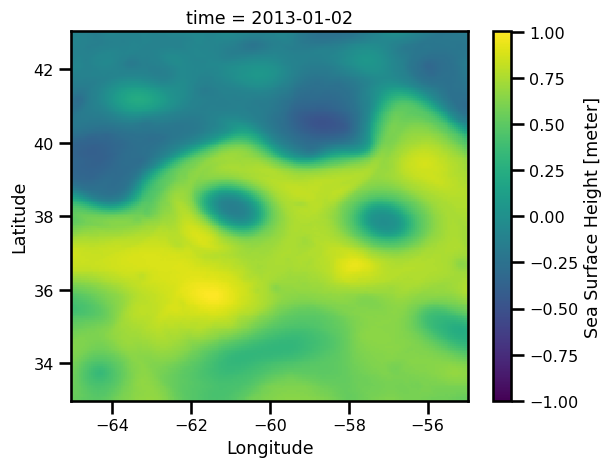

In [6]:
fig, ax = plt.subplots()

da.ssh.isel(time=1).plot.pcolormesh(ax=ax, cmap="viridis")

plt.show()

## Stream Function

$$
\begin{aligned}
\text{Stream Function }[ms^{-1}]: && 
\psi &=\boldsymbol{\psi}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\psi = \frac{g}{f_0}\eta
$$

#### Coriolis Parameter

$$
f_0 = 2\Omega\sin(\varphi)
$$

where:
* $\Omega$ - ...
* $\varphi$ - latitude (radians)

In [7]:
f0 = metpy.calc.coriolis_parameter(latitude=np.deg2rad(da.lat)).mean()
f0

<xarray.DataArray ()>
<Quantity(8.96744259e-05, '1 / second')>

#### Gravity

In [8]:
from metpy.constants import earth_gravity as GRAVITY

In [9]:
GRAVITY

9.80665 <Unit('meter / second ** 2')>

In [10]:
da = geocalc.streamfunction(da, "ssh")

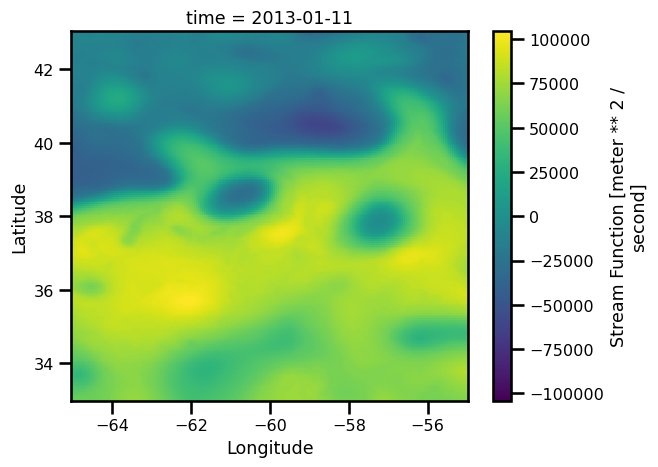

In [11]:
fig, ax = plt.subplots()

da.psi.isel(time=10).plot.pcolormesh(ax=ax, cmap="viridis")

plt.show()

## Velocities

$$
\begin{aligned}
\text{U Velocity}[ms^{-1}]: && 
u &=\boldsymbol{u}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R} \\
\text{V Velocity}[ms^{-1}]: && 
v &=\boldsymbol{v}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\psi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\begin{aligned}
u = -\frac{\partial \psi}{\partial y} && 
v = \frac{\partial \psi}{\partial x}
\end{aligned}
$$

In [12]:
da = geocalc.geostrophic_velocities(da, variable="psi")

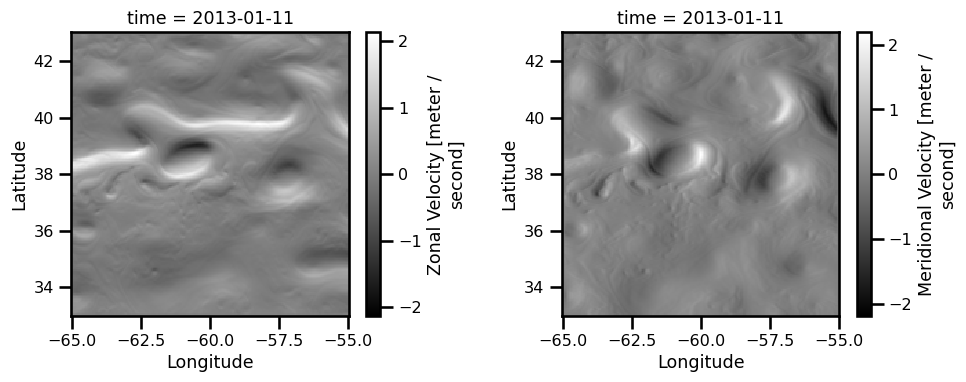

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

da.u.isel(time=10).plot.pcolormesh(ax=ax[0], cmap="gray")
da.v.isel(time=10).plot.pcolormesh(ax=ax[1], cmap="gray")

plt.tight_layout()
plt.show()

## Kinetic Energy

$$
\begin{aligned}
E &= \frac{1}{2}\int \mathbf{u}^2dr \\
E &\approx \frac{1}{2} \mathbb{E}\left[ \mathbf{u}^2\right] \\
&= \frac{1}{2} \mathbb{E}\left[ u^2 + v^2\right]
\end{aligned}
$$

In [14]:
da = geocalc.kinetic_energy(da, variables=["u", "v"])

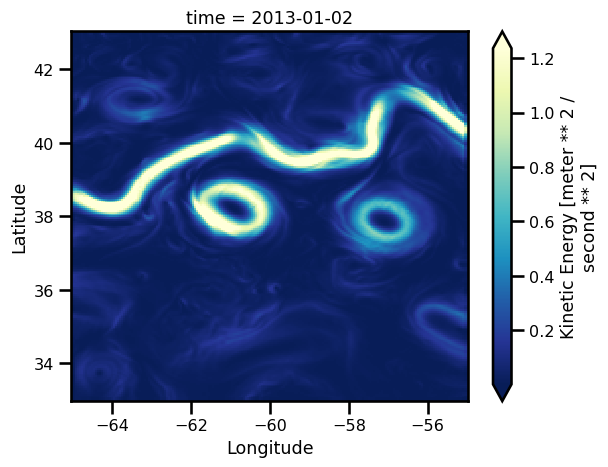

In [15]:
fig, ax = plt.subplots()

da.ke.isel(time=1).plot.pcolormesh(ax=ax, cmap="YlGnBu_r", robust=True)

plt.show()

## Relative Vorticity

Somtimes called the *vertical vorticity*.



$$
\zeta = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) - 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2}+ \frac{\partial^2 \psi}{\partial y^2}\\
\zeta &=\nabla^2\psi
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

Note: This is closely related to the geostrophic eqns:

$$
\begin{aligned}
\text{Relative Vorticity }[s^{-1}]: && 
\zeta &=\boldsymbol{\zeta}(\vec{\mathbf{x}},t) && && 
\boldsymbol{\xi}: \boldsymbol{\Omega}\times\boldsymbol{T}\rightarrow\mathbb{R}
\end{aligned}
$$

$$
\zeta = \nabla^2\psi
$$


In [16]:
da = geocalc.relative_vorticity(da, variables=["u", "v"])
da = geocalc.coriolis_normalized(da, "vort_r")

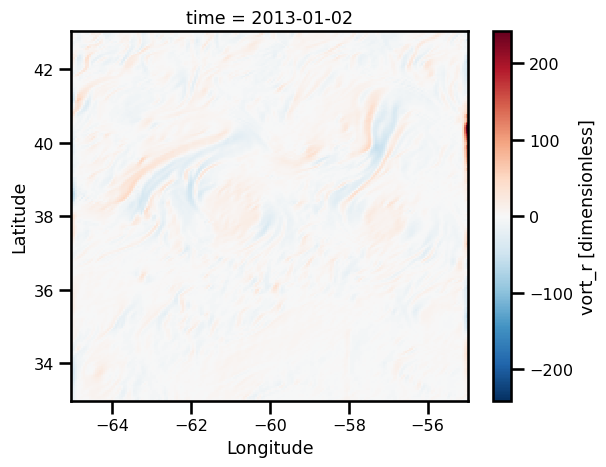

In [17]:
fig, ax = plt.subplots()

da.vort_r.isel(time=1).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

## Absolute Vorticity

Somtimes called the *horizontal divergence*.



$$
\zeta = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

Note that the u,v velocities can be calculated from the stream function as

$$
\begin{aligned}
u &= -\frac{\partial \psi}{\partial y} && &&
v = \frac{\partial \psi}{\partial x}\\
\end{aligned}
$$

So plugging these into the equation, we get:

$$
\begin{aligned}
\zeta &= 
\frac{\partial}{\partial x}\left(\frac{\partial \psi}{\partial x}\right) + 
\frac{\partial}{\partial y}\left( -\frac{\partial \psi}{\partial y}\right) \\
\zeta &= 
\frac{\partial^2 \psi}{\partial x^2} - \frac{\partial^2 \psi}{\partial y^2}
\end{aligned}
$$

We can also calculate a normalized version

$$
\bar{\zeta} = \frac{\zeta}{f_0}
$$

In [18]:
da = geocalc.absolute_vorticity(da, variables=["u", "v"])
da = geocalc.coriolis_normalized(da, "vort_a")

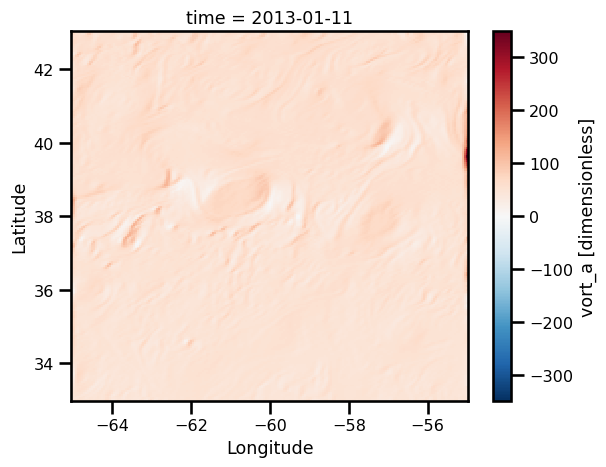

In [19]:
fig, ax = plt.subplots()

da.vort_a.isel(time=10).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

## Divergence

$$
\nabla \cdot \vec{\mathbf{u}} = \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}
$$

In [20]:
da = geocalc.divergence(da, variables=["u", "v"])
da = geocalc.coriolis_normalized(da, "div")

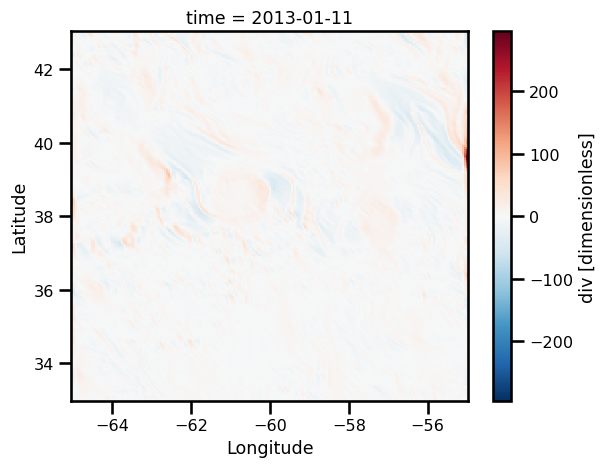

In [21]:
fig, ax = plt.subplots()

da.div.isel(time=10).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

## Enstropy

This is a summarization of the relative vorticity

$$
\begin{aligned}
Z &= \frac{1}{2}\int \zeta^2 dr \\
Z &\approx \frac{1}{2} \mathbb{E}\left[ \zeta^2 \right] \\
\end{aligned}
$$

In [22]:
da = geocalc.enstrophy(da, variable="vort_r")
da = geocalc.coriolis_normalized(da, "ens")

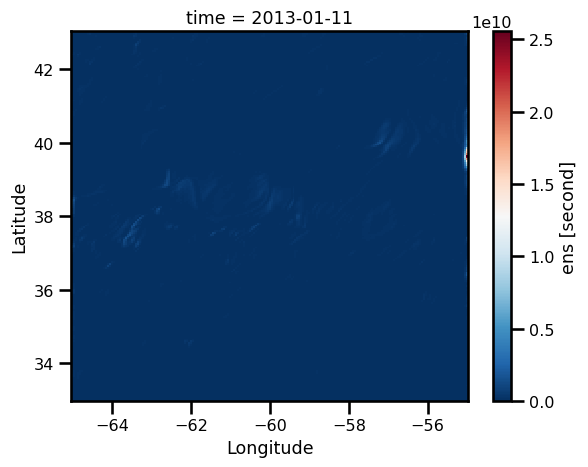

In [23]:
fig, ax = plt.subplots()

da.ens.isel(time=10).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

## Strain

### Shear Strain

We also have the *Shearing Deformation* given by:

$$
S_s = \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y}
$$

In [24]:
da = geocalc.shear_strain(da, variables=["u", "v"])
da

<xarray.Dataset>
Dimensions:       (time: 60, lat: 201, lon: 201)
Coordinates:
  * lon           (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat           (lat) float64 33.0 33.05 33.1 33.15 ... 42.85 42.9 42.95 43.0
  * time          (time) datetime64[ns] 2013-01-01 2013-01-02 ... 2013-03-01
Data variables:
    ssh           (time, lat, lon) float64 <Quantity([[[ 0.52873772  0.528737...
    psi           (time, lat, lon) float64 <Quantity([[[ 57821.90125565  5782...
    u             (time, lat, lon) float64 <Quantity([[[ 0.09819786  0.098197...
    v             (time, lat, lon) float64 <Quantity([[[ 0.06750432 -0.067504...
    ke            (time, lat, lon) float64 <Quantity([[[7.09982675e-03 7.0998...
    vort_r        (time, lat, lon) float64 <Quantity([[[-21.03727654 -13.1933...
    vort_a        (time, lat, lon) float64 <Quantity([[[26.01496319 33.858852...
    div           (time, lat, lon) float64 <Quantity([[[-22.41076683 -11.8198...
    ens           (time, lat, lon) float64 <Quantity([[[1.31080192e+08 5.1554...
    shear_strain  (time, lat, lon) float64 <Quantity([[[ 1.24743972e-08 -1.24...

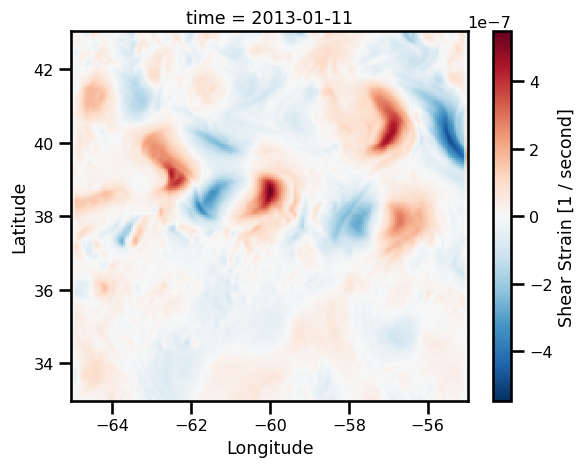

In [25]:
fig, ax = plt.subplots()

da.shear_strain.isel(time=10).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

### Normal Strain

Sometimes called *Stretching Deformation*.


$$
\sigma_n = \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y}
$$

In [26]:
da = geocalc.tensor_strain(da, variables=["u", "v"])

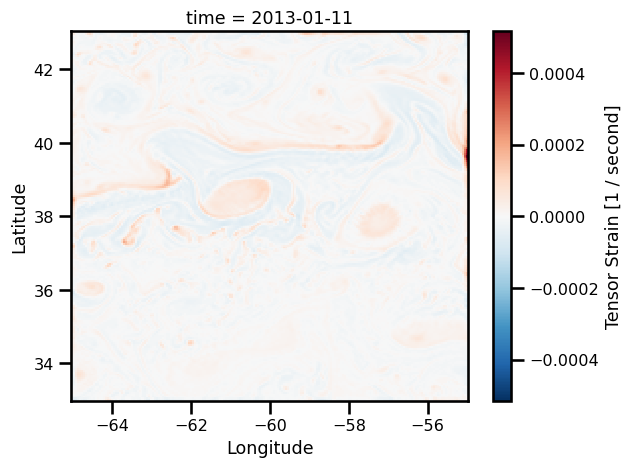

In [27]:
fig, ax = plt.subplots()

da.tensor_strain.isel(time=10).plot.pcolormesh(ax=ax, cmap="RdBu_r")

plt.show()

### Strain Magnitude

Often, we are interested in the  give by:

$$
\sigma = \sqrt{\sigma_n^2 + \sigma_s^2}
$$

**Note**: Also known as the *total deformation*.

The normal and shear strains are coordinate invariant.
The vorticity and divergence and strain magnitude is coordinate invariant!

Often times, we use the relative strain magnitude:

$$
\bar{\sigma} = \frac{\sigma}{f_0}
$$

In [28]:
da = geocalc.strain_magnitude(da, variables=["u", "v"])
da = geocalc.coriolis_normalized(da, variable="strain")

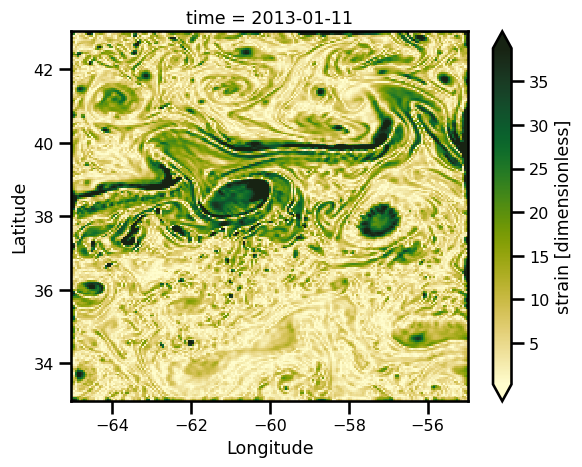

In [29]:
import cmocean as cmo

fig, ax = plt.subplots()

da.strain.isel(time=10).plot.pcolormesh(ax=ax, cmap=cmo.cm.speed, robust=True)

plt.show()

## Okubo-Weiss Parameter

> OW parameter [Okubo, 1970; Weiss, 1991] describes the relative dominance of deformation with respect to rotation of the flow.

This is a combination of the Strain (deformation rate) and the vorticity

$$
\sigma_o = \sigma_n^2 + \sigma_s^2 - \zeta^2
$$

where:

$$
\begin{aligned}
\text{Normal Strain}: && &&
\sigma_n &= \frac{\partial u}{\partial x} - \frac{\partial v}{\partial y} \\
\text{Shear Strain}: && &&
\sigma_s &= \frac{\partial v}{\partial x} + \frac{\partial u}{\partial y} \\
\text{Relative Vorticity}: && &&
\zeta &= \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{aligned}
$$

**Sources**:

* [Wiki](https://en.wikipedia.org/wiki/Okubo%E2%80%93Weiss_parameter)
* [Paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrc.20318)
* [Eddy-Tracker Python Lib](https://py-eddy-tracker.readthedocs.io/en/stable/python_module/06_grid_manipulation/pet_okubo_weiss.html)

In [30]:
da = geocalc.okubo_weiss_param(da, variables=["u", "v"])

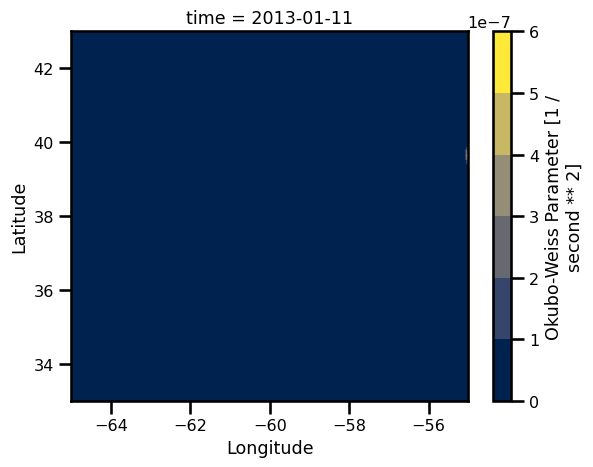

In [31]:
import cmocean as cmo

fig, ax = plt.subplots()

da.ow.isel(time=10).plot.contourf(ax=ax, cmap="cividis")

plt.show()